In [2]:
import os
import string
import requests, re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import pprint
import spacy
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
import collections
from collections import Counter
from wordcloud import WordCloud
from statistics import mean, median

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import warnings

# Data collection

This part contains code for scraping Wikipedia biographies of physicists and philosophers.

In [7]:
BASE_URL = "https://en.wikipedia.org"

In [44]:
def get_philo_list_links():
    """Returns a list of links which are list of philosophers by period."""
    url = "https://en.wikipedia.org/wiki/Category:Lists_of_philosophers_by_period"

    # Get base page
    page = requests.get(url=url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(page.content, 'html.parser')

    # Get all links in the ul
    philo_pages_link = soup.select(".mw-category-group ul li a")

    # Extract the urls
    philo_pages_url = [BASE_URL + link.get('href') for link in philo_pages_link]

    return philo_pages_url


In [45]:
def get_philo_links(list_urls):
    """Return a list of links which are about philosophers."""
    urls = []
    for url in list_urls:
        # Get list page
        page = requests.get(url=url, headers={'User-Agent': 'Mozilla/5.0'})
        soup = BeautifulSoup(page.content, 'html.parser')

        # Get all links in the ul
        # Exclude a tags with class new to avoid red links
        # Exclude last ul which is see also
        pages_link = soup.select(".mw-parser-output > ul:not(:last-of-type) > li > a:not(.new)")

        # Extract the urls
        pages_url = [BASE_URL + link.get('href') for link in pages_link]
        urls.extend(pages_url)

    return urls

In [46]:
def get_physi_list_links():
    """Returns a list of links which are list of physicists by century."""
    url = "https://en.wikipedia.org/wiki/Category:Physicists_by_century"

    # Get base page
    page = requests.get(url=url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(page.content, 'html.parser')

    # Get first level (category) links
    pages_link = soup.select(".mw-category-group:last-of-type > ul > li > .CategoryTreeSection > .CategoryTreeItem > a")
    pages_url = [BASE_URL + link.get('href') for link in pages_link]

    # Get second level (individual) links
    physi_list_urls = []
    for page_url in pages_url:
        page = requests.get(url=page_url, headers={'User-Agent': 'Mozilla/5.0'})
        soup = BeautifulSoup(page.content, 'html.parser')

        pages_link = soup.select(".mw-category-group > ul > li > .CategoryTreeSection > .CategoryTreeItem > a")
        physi_list_urls.extend([BASE_URL + link.get('href') for link in pages_link])

    return physi_list_urls

In [47]:
def get_physi_links(list_urls):
    """Return a list of links which are about physicists."""
    urls = []
    for url in list_urls:
        # Get list page
        page = requests.get(url=url, headers={'User-Agent': 'Mozilla/5.0'})
        soup = BeautifulSoup(page.content, 'html.parser')

        # Get all links in the ul
        # Exclude a tags with class new to avoid red links
        pages_link = soup.select(".mw-category > .mw-category-group > ul > li > a:not(.new)")

        # Extract the urls
        pages_url = [BASE_URL + link.get('href') for link in pages_link]
        urls.extend(pages_url)

    return urls

In [63]:
def get_page_title_content(url):
    """Return the title and content of a wikipedia page."""
    page = requests.get(url=url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(page.content, 'html.parser')

    # Get the title of the page
    title = soup.select("#firstHeading")[0].text

    # Get the content of the page
    content = soup.select("#mw-content-text > div.mw-parser-output > p")

    # Extract the text
    text = [p.text for p in content]

    # join with space, remove \n and \xa0, remove [digits], remove {style settings}
    text = " ".join(text).replace("\n", "").replace("\xa0", " ").strip()
    text = re.sub(r"\[\d+\]", "", text)
    text = re.sub(r"\{.*\}", "", text)

    return title, text

In [66]:
def write_txt(title, category, text):
    """
    Write the text to a txt file.
    title: str
    category: str, "Philosopher" or "Physicist"
    text: str
    """
    # Format the title
    title = title.title().replace(" ", "")
    title = re.sub(r"\(.*\)", "", title)

    # Create the directory if it doesn't exist
    os.makedirs(f"./part1_dataset/{category}", exist_ok=True)

    with open(f"./part1_dataset/{category}/{title}_{category}.txt", "w", encoding="utf8") as f:
        f.write(text)

In [65]:
def get_texts(list_urls, category):
    """
    Write a txt file for each url.
    list_urls: list, of urls
    category: str, "Philosopher" or "Physicist"
    Return: set, of texts
    """
    texts = set()
    for url in list_urls:
        # Get title and page content
        title, text = get_page_title_content(url)

        # Add to the set
        texts.add(text)

        # Write a txt file
        write_txt(title, category, text)

    return texts

In [61]:
# Scraping
philo_list_urls = get_philo_list_links()
philo_urls = get_philo_links(philo_list_urls)

physi_list_urls = get_physi_list_links()
physi_urls = get_physi_links(physi_list_urls)

philo_texts = get_texts(philo_urls, "Philosopher")
physi_texts = get_texts(physi_urls, "Physicist")

In [ ]:
# Create a dataframe with text-category pairs
data = [(text, "Philosopher") for text in philo_texts] + \
       [(text, "Physicist") for text in physi_texts]

df = pd.DataFrame(data, columns=["text", "category"])

In [49]:
print(f"Number of philosopher texts: {len(philo_texts)}")
print(f"Number of physicist texts: {len(physi_texts)}")
print(f"Number of texts: {len(df)}")

Number of philosopher texts: 3696
Number of physicist texts: 2763
Number of texts: 6459


# Data Analysis

In [3]:
# loading data
philo_dir = "./part1_dataset/Philosopher"
phys_dir = "./part1_dataset/Physicist"

philo_texts = []
for file in os.listdir(philo_dir):
    with open(os.path.join(philo_dir, file), 'r') as f:
        philo_texts.append(f.read())

phys_texts = []
for file in os.listdir(phys_dir):
    with open(os.path.join(phys_dir, file), 'r') as f:
        phys_texts.append(f.read())

# create dataframe with text-category pairs
data = [(text, "Philosopher") for text in philo_texts] + \
       [(text, "Physicist") for text in phys_texts]

df = pd.DataFrame(data, columns=["text", "category"])

In [4]:
df.head()

text     category
0  Dharmakīrti (fl. c. 6th or 7th century; Tibeta...  Philosopher
1  Christina M. Slade (born 1953) is an Australia...  Philosopher
2  Tsang Lap Chuen (Chinese: 曾立存) is a Chinese ph...  Philosopher
3  Callicles (/ˈkælɪkliːz/; Greek: Καλλικλῆς;  c....  Philosopher
4  Sally Haslanger (/ˈhæslæŋər/) is an American p...  Philosopher

## Text preprocessing

**Since we want to do relevant statistical analysis, we have to preprocess our data by deleting irrelevant for meaning and frequent words (stop words) and lowercase the tokens since the same word in different case is considered as two different words.**

Things to do:
* tokenize the texts
* lowercase all words
* remove punctuation
* remove stop words
* remove all non-aphabetical symbols
* normalize words

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_w = set(stopwords.words('english')) # define the stop words

[nltk_data] Downloading package punkt to /Users/hzh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/hzh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/hzh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/hzh/nltk_data...


In [8]:
def preprocess(text, remove_stop_words=True):
    
    """ 
    Remove non-ASCII chars, performs tokenization, lowercase the tokens,
    delete stopwords, punctuation and non-alphabetical characters,
    and convert tokens to normal form.

    text: str
    remove_stop_words: bool, whether to remove stop words
    Return: list, of tokens
    """
    text =  ''.join(filter(lambda x: x in string.printable, text)) # remove non-ASCII chars

    tokens = word_tokenize(text) # tokenization
    tokens = [token.lower() for token in tokens] # lowercase
    tokens = [token for token in tokens if token not in string.punctuation] # remove punctuation
    tokens = [token for token in tokens if token.isalpha()] # remove non-alphabetical characters
    
    if remove_stop_words:
        tokens = [token for token in tokens if token not in stop_w] # remove stopwords

    lemmatizer = WordNetLemmatizer()  
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # convert to normal form

    return tokens

In [9]:
df["tokens_without_sw"] = df["text"].apply(lambda x: preprocess(x))
df["tokens_sw"] = df["text"].apply(lambda x: preprocess(x, remove_stop_words=False))
df["sentences"] = df["text"].apply(lambda x: sent_tokenize(x))
df["sentences_tokens"] = df["sentences"].apply(lambda x: [preprocess(sent, remove_stop_words=True) for sent in x])

In [12]:
df.head()

text     category   
0  Dharmakīrti (fl. c. 6th or 7th century; Tibeta...  Philosopher  \
1  Christina M. Slade (born 1953) is an Australia...  Philosopher   
2  Tsang Lap Chuen (Chinese: 曾立存) is a Chinese ph...  Philosopher   
3  Callicles (/ˈkælɪkliːz/; Greek: Καλλικλῆς;  c....  Philosopher   
4  Sally Haslanger (/ˈhæslæŋər/) is an American p...  Philosopher   

                                   tokens_without_sw   
0  [dharmakrti, fl, century, tibetan, wylie, chos...  \
1  [christina, slade, born, australian, academic,...   
2  [tsang, lap, chuen, chinese, chinese, philosop...   
3  [callicles, greek, late, century, bc, thought,...   
4  [sally, haslanger, american, philosopher, prof...   

                                           tokens_sw   
0  [dharmakrti, fl, or, century, tibetan, wylie, ...  \
1  [christina, slade, born, is, an, australian, a...   
2  [tsang, lap, chuen, chinese, is, a, chinese, p...   
3  [callicles, greek, late, century, bc, is, thou...   
4  [sally, haslanger, is, an, american, philosoph...   

                                           sentences   
0  [Dharmakīrti (fl., c. 6th or 7th century; Tibe...  \
1  [Christina M. Slade (born 1953) is an Australi...   
2  [Tsang Lap Chuen (Chinese: 曾立存) is a Chinese p...   
3  [Callicles (/ˈkælɪkliːz/; Greek: Καλλικλῆς;  c...   
4  [Sally Haslanger (/ˈhæslæŋər/) is an American ...   

                                    sentences_tokens  
0  [[dharmakrti, fl], [century, tibetan, wylie, c...  
1  [[christina, slade, born, australian, academic...  
2  [[tsang, lap, chuen, chinese, chinese, philoso...  
3  [[callicles, greek, late, century, bc, thought...  
4  [[sally, haslanger, american, philosopher, pro...

## Explanatory Data Analysis

### Distribution of texts by category

<Axes: xlabel='category', ylabel='count'>

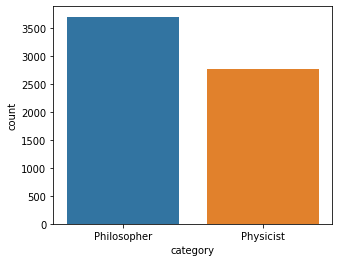

In [13]:
plt.figure(figsize=(5,4))

x= df.category.value_counts()
sns.countplot(x= "category",data=df)

## Vocabulary: statistics and plots

### Get most frequent words per category

In [15]:
# split the initial data into two datasets according to the category 
df_phil = df[df["category"] == "Philosopher"]
df_phys = df[df["category"] == "Physicist"]

In [18]:
tokens_phil_without_sw = []
tokens_phys_without_sw = []
tokens_phil_sw = []
tokens_phys_sw = []

for tokens_list in df_phil["tokens_without_sw"]:  # get all the tokens without sw for Philosopher category
    tokens_phil_without_sw += tokens_list
    
for tokens_list in df_phys["tokens_without_sw"]:  # get all the tokens without sw for Physicist category
    tokens_phys_without_sw += tokens_list
    
for tokens_list in df_phil["tokens_sw"]:  # get all the tokens with sw for Philosopher category
    tokens_phil_sw += tokens_list

for tokens_list in df_phys["tokens_sw"]:  # get all the tokens with swfor Physicist category
    tokens_phys_sw += tokens_list

In [19]:
# Get the 50 most common words for Philosopher
top_words_phil = dict(collections.Counter(tokens_phil_without_sw).most_common(50))

# Get the 50 most common words for Phiycisist
top_words_phys = dict(collections.Counter(tokens_phys_without_sw).most_common(50))

# Get the 50 most common words for Philosopher with stopwords
top_words_phil_sw = dict(collections.Counter(tokens_phil_sw).most_common(50))

# Get the 50 most common words for Phiycisist with stopwords
top_words_phys_sw = dict(collections.Counter(tokens_phys_sw).most_common(50))

### 50 most frequent words per category without stop words

In [22]:
print(f"Top 50 words for Philosopher without stopwords:")
print(list(top_words_phil.keys()))

Top 50 words for Philosopher without stopwords:
['philosophy', 'work', 'university', 'also', 'one', 'book', 'first', 'time', 'year', 'theory', 'life', 'state', 'published', 'new', 'philosopher', 'would', 'science', 'later', 'world', 'professor', 'two', 'school', 'de', 'study', 'became', 'wrote', 'human', 'idea', 'many', 'political', 'society', 'known', 'social', 'view', 'god', 'law', 'writing', 'thought', 'history', 'according', 'philosophical', 'born', 'american', 'john', 'may', 'college', 'death', 'people', 'however', 'part']


In [23]:
print(f"Top 50 words for Phisicist without stopwords:")
print(list(top_words_phys.keys()))

Top 50 words for Phisicist without stopwords:
['university', 'physic', 'research', 'science', 'professor', 'institute', 'also', 'work', 'first', 'theory', 'physicist', 'year', 'became', 'born', 'quantum', 'member', 'one', 'study', 'nuclear', 'society', 'scientific', 'academy', 'state', 'field', 'received', 'national', 'new', 'worked', 'time', 'theoretical', 'prize', 'laboratory', 'later', 'technology', 'published', 'known', 'director', 'physical', 'two', 'school', 'department', 'fellow', 'scientist', 'awarded', 'system', 'energy', 'american', 'german', 'degree', 'paper']


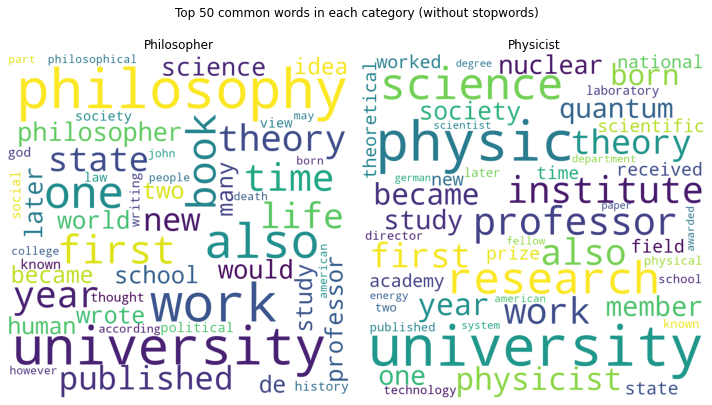

In [25]:
wordcloud_phil = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate_from_frequencies(top_words_phil)
wordcloud_phys = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate_from_frequencies(top_words_phys)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("Top 50 common words in each category (without stopwords)")

ax1.imshow(wordcloud_phil)
ax1.axis("off")
ax1.set_title("Philosopher")

ax2.imshow(wordcloud_phys)
ax2.axis("off")
ax2.set_title("Physicist")

plt.tight_layout()
plt.show()

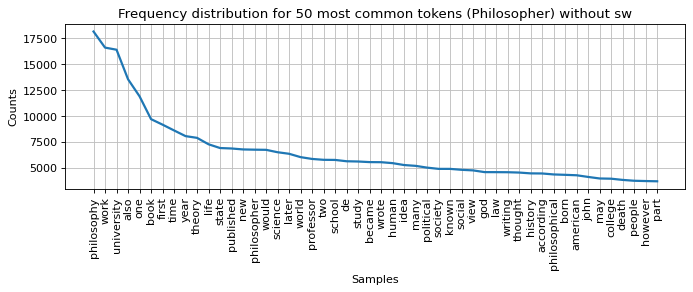

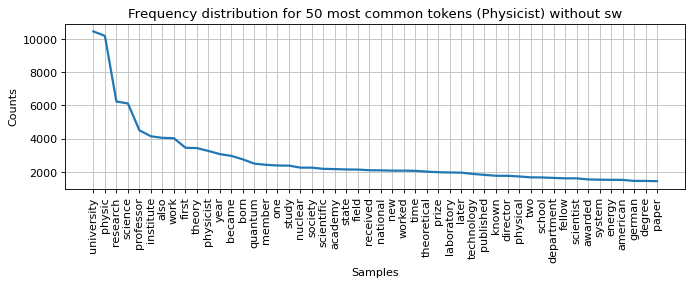

<Figure size 432x288 with 0 Axes>

In [28]:
fdist1 = FreqDist(top_words_phil)
fdist2 = FreqDist(top_words_phys)

figure(figsize=(10, 6), dpi=80)
plt.subplot(2, 1, 1)
plt.title("Frequency distribution for 50 most common tokens (Philosopher) without sw")
fdist1.plot(50)

figure(figsize=(10, 6), dpi=80)
plt.subplot(2, 1, 1)
plt.title("Frequency distribution for 50 most common tokens (Physicist) without sw")
fdist2.plot(50)

plt.tight_layout()
plt.show()

### 50 most frequent words per category with stop words

In [29]:
print(f"Top 50 words for Philosopher with stopwords:")
print(list(top_words_phil_sw.keys()))

Top 50 words for Philosopher with stopwords:
['the', 'of', 'and', 'a', 'in', 'to', 'he', 'his', 'wa', 'that', 'is', 'on', 'for', 'by', 'with', 'at', 'it', 'from', 'an', 'which', 'philosophy', 'this', 'not', 'be', 'work', 'university', 'had', 'also', 'or', 'are', 'but', 'one', 'were', 'ha', 'who', 'have', 'book', 'her', 'first', 'him', 'she', 'time', 'their', 'been', 'after', 'year', 'theory', 'other', 'all', 'they']


In [30]:
print(f"Top 50 words for Phisicist with stopwords:")
print(list(top_words_phys_sw.keys()))

Top 50 words for Phisicist with stopwords:
['the', 'of', 'in', 'and', 'a', 'to', 'he', 'wa', 'at', 'his', 'for', 'on', 'university', 'physic', 'with', 'from', 'is', 'that', 'by', 'an', 'research', 'science', 'she', 'professor', 'which', 'it', 'institute', 'also', 'work', 'this', 'first', 'had', 'theory', 'her', 'ha', 'physicist', 'after', 'year', 'were', 'became', 'born', 'where', 'quantum', 'member', 'be', 'one', 'study', 'nuclear', 'society', 'scientific']


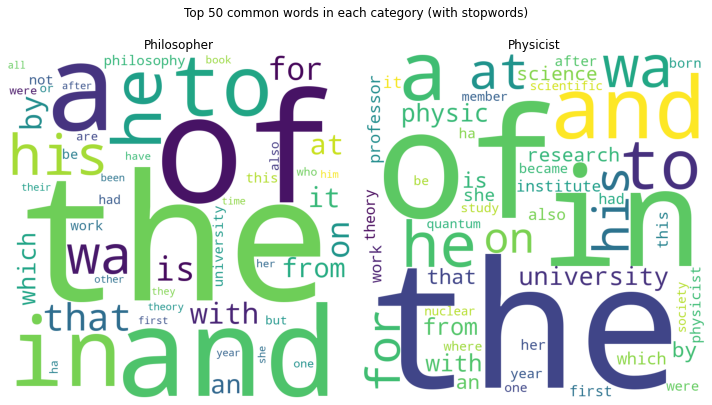

In [31]:
wordcloud_phil = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate_from_frequencies(top_words_phil_sw)
wordcloud_phys = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate_from_frequencies(top_words_phys_sw)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("Top 50 common words in each category (with stopwords)")

ax1.imshow(wordcloud_phil)
ax1.axis("off")
ax1.set_title("Philosopher")

ax2.imshow(wordcloud_phys)
ax2.axis("off")
ax2.set_title("Physicist")

plt.tight_layout()
plt.show()

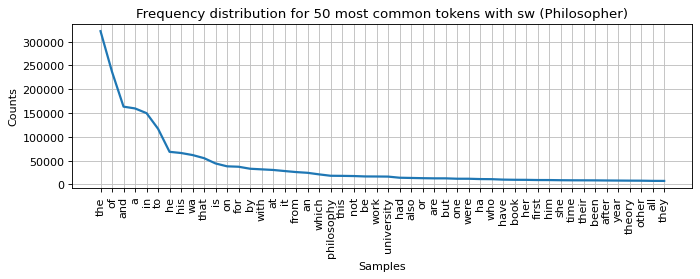

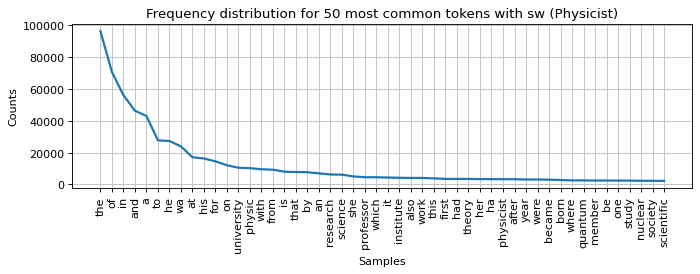

<Figure size 432x288 with 0 Axes>

In [32]:
fdist1 = FreqDist(top_words_phil_sw)
fdist2 = FreqDist(top_words_phys_sw)

figure(figsize=(10, 6), dpi=80)
plt.subplot(2, 1, 1)
plt.title("Frequency distribution for 50 most common tokens with sw (Philosopher)")
fdist1.plot(50)

figure(figsize=(10, 6), dpi=80)
plt.subplot(2, 1, 1)
plt.title("Frequency distribution for 50 most common tokens with sw (Physicist)")
fdist2.plot(50)

plt.tight_layout()
plt.show()

### Top 50 most common words in the whole corpus

In [33]:
tokens_sw = []
tokens_without_sw = []

for tokens_list in df["tokens_without_sw"]:  # get all the tokens without sw for Philosopher category
    tokens_without_sw += tokens_list
    
for tokens_list in df["tokens_sw"]:  # get all the tokens without sw for Philosopher category
    tokens_sw += tokens_list
    
# Get the 50 most common words for Philosopher
top_words = dict(collections.Counter(tokens_without_sw).most_common(50))

# Get the 50 most common words for Phiycisist
top_words_sw = dict(collections.Counter(tokens_sw).most_common(50))

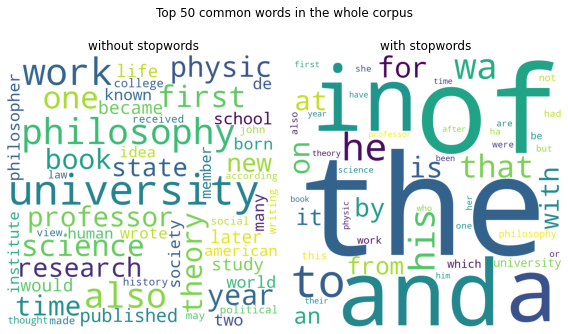

In [35]:
wordcloud_1 = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate_from_frequencies(top_words)
wordcloud_2 = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate_from_frequencies(top_words_sw)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))
fig.suptitle("Top 50 common words in the whole corpus")

ax1.imshow(wordcloud_1)
ax1.axis("off")
ax1.set_title("without stopwords")

ax2.imshow(wordcloud_2)
ax2.axis("off")
ax2.set_title("with stopwords")

plt.tight_layout()
plt.show()

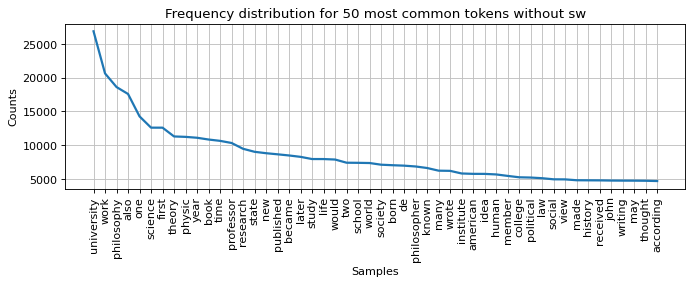

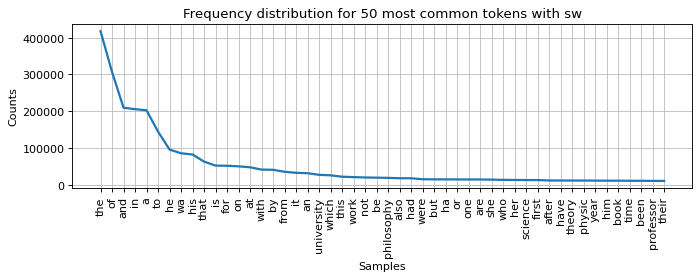

<Figure size 432x288 with 0 Axes>

In [36]:
fdist1 = FreqDist(tokens_without_sw)
fdist2 = FreqDist(tokens_sw)

figure(figsize=(10, 6), dpi=80)
plt.subplot(2, 1, 1)
plt.title("Frequency distribution for 50 most common tokens without sw")
fdist1.plot(50)

figure(figsize=(10, 6), dpi=80)
plt.subplot(2, 1, 1)
plt.title("Frequency distribution for 50 most common tokens with sw")
fdist2.plot(50)

plt.tight_layout()
plt.show()

## Tokens statistics

### Calculate tokens statistics per each category

Here we will work with tokens without considering stop words since they don't contain any significant information that could be useful for analysis.

In [38]:
df["num_tokens"] = df["tokens_without_sw"].apply(lambda x: len(x))   
df["num_of_sentences"] = df["sentences_tokens"].apply(lambda x: len(x))  # number of sentences per text
df["num_tokens_per_sentence"] = df["num_tokens"] / df["num_of_sentences"]  # average number of tokens per sentence

In [39]:
def calculate_token_statistics(df):
    
    """
    Calculate the min, max, mean and median number of tokens for each category,
    and min, max, and average number of tokens per sentence for each category.

    df: dataframe
    Returns: dataframe, of stats
    """
    df_stats = pd.DataFrame(columns=["category", "num_tokens_per_cat",  "min_num_tokens", "max_num_tokens", 
                                     "mean_num_tokens", "median_num_tokens", "min_num_tokens_per_sentence",
                                     "max_num_tokens_per_sentence", "mean_num_tokens_per_sentence"])
    
    df_stats["category"] = df["category"].unique()
    df_stats.set_index("category", inplace=True)
    
    df_stats["num_tokens_per_cat"] = df.groupby("category")["num_tokens"].sum() # total number of tokens per category
    df_stats["min_num_tokens"] = df.groupby("category")["num_tokens"].min() # min number of tokens per category
    df_stats["max_num_tokens"] = df.groupby("category")["num_tokens"].max() # max number of tokens per category
    df_stats["mean_num_tokens"] = df.groupby("category")["num_tokens"].mean() # average number of tokens per category
    df_stats["median_num_tokens"] = df.groupby("category")["num_tokens"].median() # median number of tokens per category

    df_stats["min_num_tokens_per_sentence"] = df.groupby("category")["num_tokens_per_sentence"].min() # min number of tokens per sentence per category
    df_stats["max_num_tokens_per_sentence"] = df.groupby("category")["num_tokens_per_sentence"].max() # max number of tokens per sentence per category
    df_stats["mean_num_tokens_per_sentence"] = df.groupby("category")["num_tokens_per_sentence"].mean() # average number of tokens per sentence per category
    df_stats["median_num_tokens_per_sentence"] = df.groupby("category")["num_tokens_per_sentence"].median() # median number of tokens per sentence per category
     
    return df_stats

In [41]:
stats = calculate_token_statistics(df)
stats

num_tokens_per_cat  min_num_tokens  max_num_tokens   
category                                                          
Philosopher             2709868               7           10919  \
Physicist                790299               8            6156   

             mean_num_tokens  median_num_tokens  min_num_tokens_per_sentence   
category                                                                       
Philosopher       733.189394              317.0                     4.186047  \
Physicist         286.029316              181.0                     3.398936   

             max_num_tokens_per_sentence  mean_num_tokens_per_sentence   
category                                                                 
Philosopher                         26.5                     11.978490  \
Physicist                           38.0                     11.429013   

             median_num_tokens_per_sentence  
category                                     
Philosopher                       12.000000  
Physicist                         11.166667

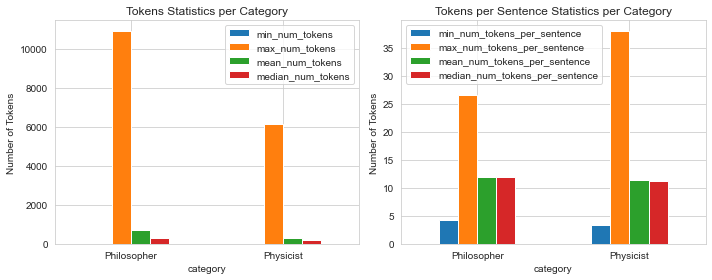

In [42]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

stats[["min_num_tokens", "max_num_tokens", "mean_num_tokens", "median_num_tokens"]].plot(
    kind="bar", ax=axes[0], title="Tokens Statistics per Category", rot=0)
axes[0].set_ylabel("Number of Tokens")
axes[0].legend(title=None)

stats[["min_num_tokens_per_sentence", "max_num_tokens_per_sentence", "mean_num_tokens_per_sentence",
       "median_num_tokens_per_sentence"]].plot(
    kind="bar", ax=axes[1], title="Tokens per Sentence Statistics per Category", rot=0)
axes[1].set_ylabel("Number of Tokens")
axes[1].legend(title=None)

plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.show()

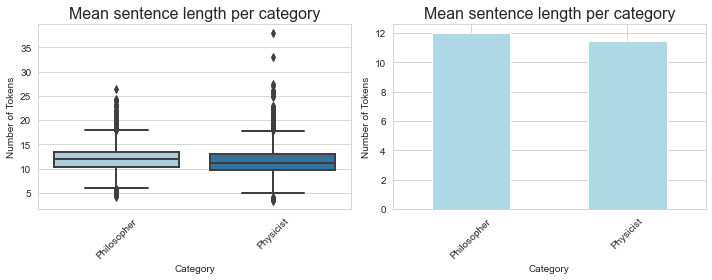

In [43]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

mean_data = df.groupby("category")["num_tokens_per_sentence"].mean()
sns.boxplot(x=df["category"], y=df["num_tokens_per_sentence"], palette="Paired", linewidth=2, ax=axes[0])
axes[0].set_title("Mean sentence length per category", fontsize=16)
axes[0].set_xlabel("Category", fontsize=10)
axes[0].set_ylabel("Number of Tokens", fontsize=10)
axes[0].tick_params(axis='x', labelrotation=45)

mean_data.plot(kind="bar", color="LightBlue", rot=0, ax=axes[1])
axes[1].set_title("Mean sentence length per category", fontsize=16)
axes[1].set_xlabel("Category", fontsize=10)
axes[1].set_ylabel("Number of Tokens", fontsize=10)
axes[1].tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

## Sentence statistics

In [44]:
def calculate_sentence_stats(df):
    
    """
    calculate the min, max, mean and median number of sentences for each category.

    df: dataframe
    Returns: dataframe, of stats
    """
    df_stats = pd.DataFrame(columns=["category", "min_num_sentences", "max_num_sentences", 
                                  "avg_num_sentences", "median_num_sentences"])
    
    df_stats["category"] = df["category"].unique()
    df_stats.set_index("category", inplace=True)
    
    df_stats["min_num_sentences"] = df.groupby("category")["num_of_sentences"].min() # min number of sentences per category
    df_stats["max_num_sentences"] = df.groupby("category")["num_of_sentences"].max() # max number of sentences per category
    df_stats["avg_num_sentences"] = df.groupby("category")["num_of_sentences"].mean() # average number of sentences per category
    df_stats["median_num_sentences"] = df.groupby("category")["num_of_sentences"].median() # median number of sentences per category
    
    return df_stats

In [45]:
sent_stats = calculate_sentence_stats(df)
sent_stats

min_num_sentences  max_num_sentences  avg_num_sentences   
category                                                               
Philosopher                  1                906          58.227002  \
Physicist                    1                501          24.464712   

             median_num_sentences  
category                           
Philosopher                  27.0  
Physicist                    17.0

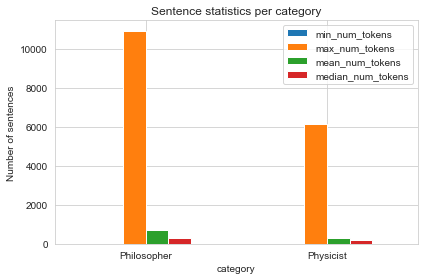

In [46]:
stats[["min_num_tokens", "max_num_tokens", "mean_num_tokens", "median_num_tokens"]].plot(
    kind="bar", title="Sentence statistics per category", rot=0)

plt.ylabel("Number of sentences")
plt.legend(title=None)

plt.tight_layout()
plt.show()

## POS tagging and Named entity recognition (TBC)

### Vocabularies of POS

Spacy is used for getting POS information.

In [48]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
df["merged_tokens"] = df["tokens_without_sw"].apply(lambda x: " ".join(x)) #
df["POS_tags"] = df["merged_tokens"].apply(lambda x: nlp(x)) # POS tagging
df["POS_tags"] = df["POS_tags"].apply(lambda x: [token.pos_ for token in x]) # POS tagging
df["pos_token"] = df["POS_tags"].apply(lambda x: list(zip(x, df["tokens_without_sw"]))) # zip the tokens with their POS tags

# Classification

In [3]:
warnings.filterwarnings('ignore')
random_state = 0

In [5]:
# if starting from here: 
# run Text processing in Data Analysis first

# df = pd.read_csv("./processed_data.csv")
# df.head()

text     category   
0  Dharmakīrti (fl. c. 6th or 7th century; Tibeta...  Philosopher  \
1  Christina M. Slade (born 1953) is an Australia...  Philosopher   
2  Tsang Lap Chuen (Chinese: 曾立存) is a Chinese ph...  Philosopher   
3  Callicles (/ˈkælɪkliːz/; Greek: Καλλικλῆς;  c....  Philosopher   
4  Sally Haslanger (/ˈhæslæŋər/) is an American p...  Philosopher   

                                   tokens_without_sw   
0  ['dharmakrti', 'fl', 'century', 'tibetan', 'wy...  \
1  ['christina', 'slade', 'born', 'australian', '...   
2  ['tsang', 'lap', 'chuen', 'chinese', 'chinese'...   
3  ['callicles', 'greek', 'late', 'century', 'bc'...   
4  ['sally', 'haslanger', 'american', 'philosophe...   

                                           tokens_sw   
0  ['dharmakrti', 'fl', 'or', 'century', 'tibetan...  \
1  ['christina', 'slade', 'born', 'is', 'an', 'au...   
2  ['tsang', 'lap', 'chuen', 'chinese', 'is', 'a'...   
3  ['callicles', 'greek', 'late', 'century', 'bc'...   
4  ['sally', 'haslanger', 'is', 'an', 'american',...   

                                           sentences   
0  ['Dharmakīrti (fl.', 'c.\u20096th or 7th centu...  \
1  ['Christina M. Slade (born 1953) is an Austral...   
2  ['Tsang Lap Chuen (Chinese: 曾立存) is a Chinese ...   
3  ['Callicles (/ˈkælɪkliːz/; Greek: Καλλικλῆς;  ...   
4  ['Sally Haslanger (/ˈhæslæŋər/) is an American...   

                                    sentences_tokens  
0  [['dharmakrti', 'fl'], ['century', 'tibetan', ...  
1  [['christina', 'slade', 'born', 'australian', ...  
2  [['tsang', 'lap', 'chuen', 'chinese', 'chinese...  
3  [['callicles', 'greek', 'late', 'century', 'bc...  
4  [['sally', 'haslanger', 'american', 'philosoph...

In [6]:
df.describe()

text     category   
count                                                6459         6459  \
unique                                               6432            2   
top     Mario Augusto Bunge (/ˈbʊŋɡeɪ/; Spanish: [ˈbuŋ...  Philosopher   
freq                                                    2         3696   

                                        tokens_without_sw   
count                                                6459  \
unique                                               6432   
top     ['mario', 'augusto', 'bunge', 'spanish', 'buxe...   
freq                                                    2   

                                                tokens_sw   
count                                                6459  \
unique                                               6432   
top     ['mario', 'augusto', 'bunge', 'spanish', 'buxe...   
freq                                                    2   

                                                sentences   
count                                                6459  \
unique                                               6432   
top     ['Mario Augusto Bunge (/ˈbʊŋɡeɪ/; Spanish: [ˈb...   
freq                                                    2   

                                         sentences_tokens  
count                                                6459  
unique                                               6432  
top     [['mario', 'augusto', 'bunge', 'spanish', 'bux...  
freq                                                    2

## Data Preparation

In [7]:
# Create a dict mapping an integer to a category
dic = {}
for top in df['category'].unique():
    dic[len(dic) + 1] = top
print(dic)

{1: 'Philosopher', 2: 'Physicist'}


In [8]:
# Create a reverse dict
dic_revers = {}
for k in dic:
    dic_revers[dic[k]] = k
print(dic_revers)

{'Philosopher': 1, 'Physicist': 2}


In [60]:
# Create a column "label"
def preproc(label):
  return dic_revers[label]

df['label'] = df['category'].apply(preproc)
df['label'].unique()

array([1, 2])

In [10]:
df.head()

text     category   
0  Dharmakīrti (fl. c. 6th or 7th century; Tibeta...  Philosopher  \
1  Christina M. Slade (born 1953) is an Australia...  Philosopher   
2  Tsang Lap Chuen (Chinese: 曾立存) is a Chinese ph...  Philosopher   
3  Callicles (/ˈkælɪkliːz/; Greek: Καλλικλῆς;  c....  Philosopher   
4  Sally Haslanger (/ˈhæslæŋər/) is an American p...  Philosopher   

                                   tokens_without_sw   
0  ['dharmakrti', 'fl', 'century', 'tibetan', 'wy...  \
1  ['christina', 'slade', 'born', 'australian', '...   
2  ['tsang', 'lap', 'chuen', 'chinese', 'chinese'...   
3  ['callicles', 'greek', 'late', 'century', 'bc'...   
4  ['sally', 'haslanger', 'american', 'philosophe...   

                                           tokens_sw   
0  ['dharmakrti', 'fl', 'or', 'century', 'tibetan...  \
1  ['christina', 'slade', 'born', 'is', 'an', 'au...   
2  ['tsang', 'lap', 'chuen', 'chinese', 'is', 'a'...   
3  ['callicles', 'greek', 'late', 'century', 'bc'...   
4  ['sally', 'haslanger', 'is', 'an', 'american',...   

                                           sentences   
0  ['Dharmakīrti (fl.', 'c.\u20096th or 7th centu...  \
1  ['Christina M. Slade (born 1953) is an Austral...   
2  ['Tsang Lap Chuen (Chinese: 曾立存) is a Chinese ...   
3  ['Callicles (/ˈkælɪkliːz/; Greek: Καλλικλῆς;  ...   
4  ['Sally Haslanger (/ˈhæslæŋər/) is an American...   

                                    sentences_tokens  label  
0  [['dharmakrti', 'fl'], ['century', 'tibetan', ...      1  
1  [['christina', 'slade', 'born', 'australian', ...      1  
2  [['tsang', 'lap', 'chuen', 'chinese', 'chinese...      1  
3  [['callicles', 'greek', 'late', 'century', 'bc...      1  
4  [['sally', 'haslanger', 'american', 'philosoph...      1

In [11]:
df.label.value_counts(normalize=True)

label
1    0.572225
2    0.427775
Name: proportion, dtype: float64

In [12]:
# Split the data into training and testing sets
X = df['tokens_without_sw']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [13]:
# Using TFIDF vectorizer to convert words to vectors
tfidf_vectorizer = TfidfVectorizer(max_features=1000,
                                    use_idf=True,
                                    ngram_range=(1, 3))
# Fit the vectorizer to train and test data
X_train_vec = tfidf_vectorizer.fit_transform(X_train)
X_test_vec = tfidf_vectorizer.transform(X_test)

In [14]:
# Printing out the features
features = tfidf_vectorizer.get_feature_names_out()
print(features)

['ability' 'able' 'absolute' 'academic' 'academy' 'academy science'
 'accepted' 'according' 'account' 'achievement' 'act' 'action' 'active'
 'activity' 'adam' 'addition' 'advanced' 'aesthetic' 'affair' 'age' 'air'
 'albert' 'alexander' 'allowed' 'almost' 'along' 'already' 'also'
 'although' 'always' 'america' 'american' 'among' 'analysis' 'ancient'
 'animal' 'another' 'appeared' 'appears' 'application' 'applied'
 'appointed' 'appointment' 'approach' 'april' 'area' 'argued' 'argues'
 'argument' 'aristotle' 'army' 'around' 'art' 'article' 'asked' 'aspect'
 'assistant' 'associate' 'associated' 'association' 'astronomy' 'atomic'
 'attack' 'attempt' 'attended' 'attention' 'attributed' 'august' 'author'
 'authority' 'award' 'awarded' 'away' 'bachelor' 'back' 'based' 'basic'
 'basis' 'bc' 'became' 'become' 'becoming' 'began' 'beginning' 'being'
 'belief' 'believe' 'believed' 'berkeley' 'berlin' 'best' 'best known'
 'better' 'beyond' 'biography' 'birth' 'bishop' 'black' 'board' 'body'
 'bohr' 

In [16]:
print('Train set shape:', X_train_vec.shape)
print('Test set shape:', X_test_vec.shape)
print('Vocabulary size:', len(tfidf_vectorizer.vocabulary_))

Train set shape: (5167, 1000)
Test set shape: (1292, 1000)
Vocabulary size: 1000


## Training and Testing Classifiers

Here we compare two classifiers: perceptron and logistic regression.

In [63]:
def cm_calculate(y_test, y_pred):
    """
    Calculate confusion matrix for the model

    y_test: true labels
    y_pred: predicted labels

    Return: confusion matrix
    """
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix:', '\n', cm)

    return cm

In [65]:
def cm_visualize(cm, model_name):
    """
    Visualize the confusion matrix

    cm: confusion matrix
    model_name: str, "Perceptron", "Logistic Regression", "Decision Tree", "Multinomial Naive Bayes", "Random Forest"
    """
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.summer)
    class_names = ['Negative','Positive']
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    s = [['TN','FP'], ['FN', 'TP']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

### Perceptron

In [61]:
clf_perc = Perceptron(random_state=random_state)

# Train the model
clf_perc.fit(X_train_vec, y_train)

# Predict the labels of the test instances
y_pred_perc = clf_perc.predict(X_test_vec)

In [62]:
# Evaluate the model
print('Classification report:', '\n', classification_report(y_test, y_pred_perc, digits=3))
f1_perc = f1_score(y_test, y_pred_perc)

Classification report: 
               precision    recall  f1-score   support

           1      0.952     0.992     0.972       747
           2      0.988     0.932     0.959       545

    accuracy                          0.967      1292
   macro avg      0.970     0.962     0.966      1292
weighted avg      0.968     0.967     0.967      1292



In [64]:
# Print the confusion matrix
cm_perc = cm_calculate(y_test, y_pred_perc)

Confusion matrix: 
 [[741   6]
 [ 37 508]]


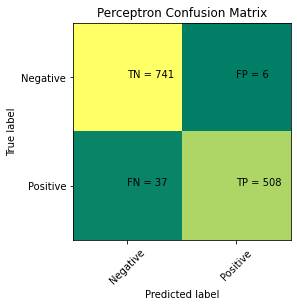

In [66]:
# Visualize the confusion matrix
cm_visualize(cm_perc, 'Perceptron')

### Perceptron with K-fold CV

In [67]:
# Do the same steps as above, but this time with K-fold cross validation
# Check for overfitting (as above we've got pretty good results)

X = df['tokens_sw']
y = df['label']

tfidf_vectorizer = TfidfVectorizer(max_features=1000,
                                    use_idf=True,
                                    ngram_range=(1, 3))

X_vec = tfidf_vectorizer.fit_transform(X)

clf_perc_kf = Perceptron(max_iter=5, random_state=random_state, tol=None)

scores_perc_kf = cross_validate(clf_perc_kf, X_vec, y, cv=5, scoring='f1')

print("%0.3f f1 with a standard deviation of %0.3f" % (scores_perc_kf['test_score'].mean(), scores_perc_kf['test_score'].std()))

0.977 f1 with a standard deviation of 0.007


### Logistic Regression

In [22]:
clf_log = LogisticRegression(random_state=random_state)

# Train  the model
clf_log.fit(X_train_vec, y_train)

# Predict the labels of the test instances
y_pred_log = clf_log.predict(X_test_vec)

# Evaluating a classifier
print('Classification report:', '\n', classification_report(y_test, y_pred_log, digits=3))
f1_log = f1_score(y_test, y_pred_log)

Classification report: 
               precision    recall  f1-score   support

           1      0.988     0.988     0.988       747
           2      0.983     0.983     0.983       545

    accuracy                          0.986      1292
   macro avg      0.986     0.986     0.986      1292
weighted avg      0.986     0.986     0.986      1292



In [23]:
# Print the confusion matrix
cm_log = cm_calculate(y_test, y_pred_log)

Confusion matrix: 
 [[738   9]
 [  9 536]]


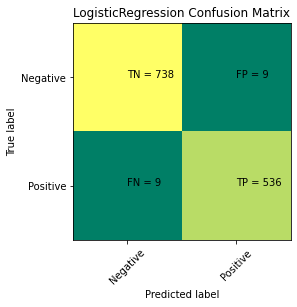

In [24]:
# Visualize the confusion matrix
cm_visualize(cm_log, 'Logistic Regression')

### Decision Tree

In [25]:
clf_dt = DecisionTreeClassifier(random_state=random_state)

# Train  the model
clf_dt.fit(X_train_vec, y_train)

# Predict the labels of the test instances
y_pred_dt = clf_dt.predict(X_test_vec)

# Evaluating a classifier
print('Classification report:', '\n', classification_report(y_test, y_pred_dt, digits=3))
f1_dt = f1_score(y_test, y_pred_dt)

Classification report: 
               precision    recall  f1-score   support

           1      0.966     0.963     0.964       747
           2      0.949     0.954     0.952       545

    accuracy                          0.959      1292
   macro avg      0.958     0.958     0.958      1292
weighted avg      0.959     0.959     0.959      1292



In [26]:
# Print the confusion matrix
cm_dt = cm_calculate(y_test, y_pred_dt)

Confusion matrix: 
 [[719  28]
 [ 25 520]]


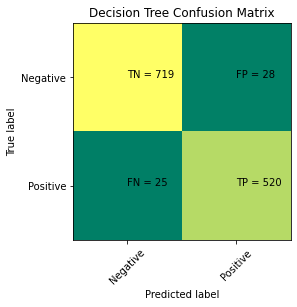

In [27]:
# Print the confusion matrix in a pretty way
cm_visualize(cm_dt, 'Decision Tree')

### Multinimonal Naive Bayes

In [28]:
clf_nb = MultinomialNB()

# Train  the model
clf_nb.fit(X_train_vec, y_train)

# Predict the labels of the test instances
y_pred_nb = clf_nb.predict(X_test_vec)

# Evaluating a classifier
print('Classification report:', '\n', classification_report(y_test, y_pred_nb, digits=3))
f1_nb = f1_score(y_test, y_pred_nb)

Classification report: 
               precision    recall  f1-score   support

           1      0.981     0.983     0.982       747
           2      0.976     0.974     0.975       545

    accuracy                          0.979      1292
   macro avg      0.979     0.978     0.979      1292
weighted avg      0.979     0.979     0.979      1292



In [29]:
# Print the confusion matrix
cm_nb = cm_calculate(y_test, y_pred_nb)

Confusion matrix: 
 [[734  13]
 [ 14 531]]


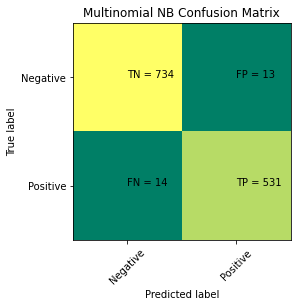

In [30]:
# Print the confusion matrix in a pretty way
cm_visualize(cm_nb, 'Multinomial Naive Bayes')

### Random Forest

In [31]:
clf_rf = RandomForestClassifier(random_state=random_state)

# Train  the model
clf_rf.fit(X_train_vec, y_train)

# Predict the labels of the test instances
y_pred_rf = clf_rf.predict(X_test_vec)

# Evaluating a classifier
print('Classification report:', '\n', classification_report(y_test, y_pred_rf, digits=3))
f1_rf = f1_score(y_test, y_pred_rf)

Classification report: 
               precision    recall  f1-score   support

           1      0.985     0.985     0.985       747
           2      0.980     0.980     0.980       545

    accuracy                          0.983      1292
   macro avg      0.983     0.983     0.983      1292
weighted avg      0.983     0.983     0.983      1292



In [32]:
# Print the confusion matrix
cm_rf = cm_calculate(y_test, y_pred_rf)

Confusion matrix: 
 [[736  11]
 [ 11 534]]


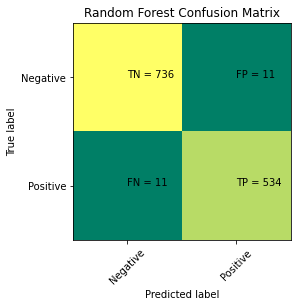

In [33]:
# Visualize the confusion matrix
cm_visualize(cm_rf, 'Random Forest')

### Compare the models

In [34]:
# Compare models using f1 score
print(f"""
    Logistic Regression: {f1_log}\n
    Perceptron: {f1_perc}\n
    Decision Tree: {f1_dt}\n
    Random Forest: {f1_rf}\n
    Multinominal NB: {f1_nb}
    """)

Logistic Regression: 0.9879518072289156
Perceptron: 0.9718032786885247
Decision Tree: 0.9644533869885983
Random Forest: 0.9852744310575636
Multinominal NB: 0.9819397993311038


## Training and Testing Top-2 Classifiers

### CountVectorizer

In [68]:
# Split the data into training and testing sets
X = df['tokens_without_sw']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=random_state, shuffle=True)

In [69]:
# Using CountVectorizer to convert words to vectors
count_vectorizer = CountVectorizer(max_features=1000,
                                   analyzer='word', 
                                   ngram_range=(1, 3))

# Fit the vectorizer to train and test data
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

In [70]:
# Printing out the features
print(count_vectorizer.get_feature_names_out())

['ability' 'able' 'absolute' 'academic' 'academy' 'academy science'
 'accepted' 'according' 'account' 'achievement' 'act' 'action' 'active'
 'activity' 'adam' 'addition' 'advanced' 'aesthetic' 'affair' 'age' 'air'
 'albert' 'alexander' 'allowed' 'almost' 'along' 'already' 'also'
 'although' 'always' 'america' 'american' 'among' 'analysis' 'ancient'
 'animal' 'another' 'appeared' 'appears' 'application' 'applied'
 'appointed' 'appointment' 'approach' 'april' 'area' 'argued' 'argues'
 'argument' 'aristotle' 'army' 'around' 'art' 'article' 'asked' 'aspect'
 'assistant' 'associate' 'associated' 'association' 'astronomy' 'atomic'
 'attack' 'attempt' 'attended' 'attention' 'attributed' 'august' 'author'
 'authority' 'award' 'awarded' 'away' 'bachelor' 'back' 'based' 'basic'
 'basis' 'bc' 'became' 'become' 'becoming' 'began' 'beginning' 'being'
 'belief' 'believe' 'believed' 'berkeley' 'berlin' 'best' 'best known'
 'better' 'beyond' 'biography' 'birth' 'bishop' 'black' 'board' 'body'
 'bohr' 

#### Logistic Regression with GridSearchCV

In [37]:
parameters = {
    'penalty' : ['none', 'l1', 'l2', 'elasticnet'], 
    'C'       : [100, 10, 1.0, 0.1, 0.01],
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

log = LogisticRegression(random_state=random_state)
clf_log_count_cv = GridSearchCV(log,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='f1',              # metric for scoring
                   cv=5)                      # number of folds

clf_log_count_cv.fit(X_train_count, y_train)

print("Tuned Hyperparameters: ", clf_log_count_cv.best_params_)
print("F1: ", clf_log_count_cv.best_score_)

Tuned Hyperparameters:  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
F1:  0.9819027120091647


In [38]:
# Using the best parameters
clf_log_count_best = LogisticRegression(C=0.01, penalty='l2', 
                                  solver='liblinear', random_state=random_state)

# Train  the model
clf_log_count_best.fit(X_train_count, y_train)

# Predict the labels of the test instances
y_pred_log_count_best = clf_log_count_best.predict(X_test_count)

# Evaluating a classifier
print('Classification report:', '\n', classification_report(y_test, y_pred_log_count_best, digits=3))
f1_log_count_best = f1_score(y_test, y_pred_log_count_best)

Classification report: 
               precision    recall  f1-score   support

           1      0.992     0.980     0.986       747
           2      0.973     0.989     0.981       545

    accuracy                          0.984      1292
   macro avg      0.982     0.984     0.983      1292
weighted avg      0.984     0.984     0.984      1292



In [39]:
# Print the confusion matrix
cm_log_count_best = cm_calculate(y_test, y_pred_log_count_best)

Confusion matrix: 
 [[732  15]
 [  6 539]]


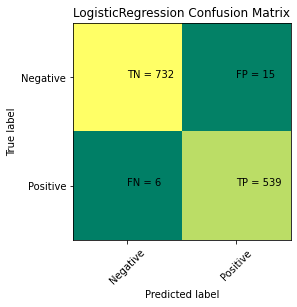

In [40]:
# Visualize the confusion matrix
cm_visualize(cm_log_count_best, 'Logistic Regression')

#### Random Forest with GridSearchCV

In [41]:
parameters = {
    # 'max_depth': list(range(10, 15)), 
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [100, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
}

rf = RandomForestClassifier(random_state=random_state)
clf_rf_count_cv = GridSearchCV(rf,                     # model
                   param_grid = parameters,   # hyperparameters
                   scoring='f1',              # metric for scoring
                   cv=5)                     # number of folds

clf_rf_count_cv.fit(X_train_count, y_train)

print("Tuned Hyperparameters: ", clf_rf_count_cv.best_params_)
print("F1: ", clf_rf_count_cv.best_score_)

Tuned Hyperparameters:  {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}
F1:  0.9830067062234594


In [42]:
# Using the best parameters
clf_rf_count_best = RandomForestClassifier(criterion='gini', 
                                     max_features='sqrt', 
                                     n_estimators=100, 
                                     random_state=random_state)

# Train  the model
clf_rf_count_best.fit(X_train_count, y_train)

# Predict the labels of the test instances
y_pred_rf_count_best = clf_rf_count_best.predict(X_test_count)

# Evaluating a classifier
print('Classification report:', '\n', classification_report(y_test, y_pred_rf_count_best, digits=3))
f1_rf_count_best = f1_score(y_test, y_pred_rf_count_best)

Classification report: 
               precision    recall  f1-score   support

           1      0.981     0.988     0.985       747
           2      0.983     0.974     0.979       545

    accuracy                          0.982      1292
   macro avg      0.982     0.981     0.982      1292
weighted avg      0.982     0.982     0.982      1292



In [43]:
# Print the confusion matrix
cm_rf_count_best = cm_calculate(y_test, y_pred_rf_count_best)

Confusion matrix: 
 [[738   9]
 [ 14 531]]


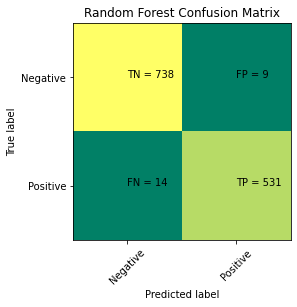

In [44]:
# Visualize the confusion matrix
cm_visualize(cm_rf_count_best, 'Random Forest')

### TFIDF Vectorizer

In [71]:
# Using TFIDF vectorizer to convert words to vectors
tfidf_vectorizer = TfidfVectorizer(max_features=1000,
                                    use_idf=True,
                                    ngram_range=(1, 3))

# Fit the vectorizer to train and test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [47]:
# Printing out the features
print(tfidf_vectorizer.get_feature_names_out())

['ability' 'able' 'absolute' 'academic' 'academy' 'academy science'
 'accepted' 'according' 'account' 'achievement' 'act' 'action' 'active'
 'activity' 'adam' 'addition' 'advanced' 'aesthetic' 'affair' 'age' 'air'
 'albert' 'alexander' 'allowed' 'almost' 'along' 'already' 'also'
 'although' 'always' 'america' 'american' 'among' 'analysis' 'ancient'
 'animal' 'another' 'appeared' 'appears' 'application' 'applied'
 'appointed' 'appointment' 'approach' 'april' 'area' 'argued' 'argues'
 'argument' 'aristotle' 'army' 'around' 'art' 'article' 'asked' 'aspect'
 'assistant' 'associate' 'associated' 'association' 'astronomy' 'atomic'
 'attack' 'attempt' 'attended' 'attention' 'attributed' 'august' 'author'
 'authority' 'award' 'awarded' 'away' 'bachelor' 'back' 'based' 'basic'
 'basis' 'bc' 'became' 'become' 'becoming' 'began' 'beginning' 'being'
 'belief' 'believe' 'believed' 'berkeley' 'berlin' 'best' 'best known'
 'better' 'beyond' 'biography' 'birth' 'bishop' 'black' 'board' 'body'
 'bohr' 

In [72]:
print('Train set shape:', X_train_vec.shape)
print('Test set shape:', X_test_vec.shape)
print('Vocabulary size:', len(tfidf_vectorizer.vocabulary_))

Train set shape: (5167, 1000)
Test set shape: (1292, 1000)
Vocabulary size: 1000


#### Logistic Regression with GridSearchCV

In [49]:
parameters = {
    'penalty' : ['none', 'l1', 'l2', 'elasticnet'], 
    'C'       : [100, 10, 1.0, 0.1, 0.01],
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

log = LogisticRegression(random_state=random_state)
clf_log_tfidf_cv = GridSearchCV(log,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='f1',              # metric for scoring
                   cv=5)                     # number of folds

clf_log_tfidf_cv.fit(X_train_tfidf, y_train)

print("Tuned Hyperparameters: ", clf_log_tfidf_cv.best_params_)
print("F1: ", clf_log_tfidf_cv.best_score_)

Tuned Hyperparameters:  {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
F1:  0.9828027748309877


In [50]:
# Using the best parameters
clf_log_tfidf_best = LogisticRegression(C=1.0, penalty='l2', 
                                        solver='liblinear', random_state=random_state)

# Train  the model
clf_log_tfidf_best.fit(X_train_tfidf, y_train)

# Predict the labels of the test instances
y_pred_log_tfidf_best = clf_log_tfidf_best.predict(X_test_tfidf)

# Evaluating a classifier
print('Classification report:', '\n', classification_report(y_test, y_pred_log_tfidf_best, digits=3))
f1_log_tfidf_best = f1_score(y_test, y_pred_log_tfidf_best)

Classification report: 
               precision    recall  f1-score   support

           1      0.988     0.988     0.988       747
           2      0.983     0.983     0.983       545

    accuracy                          0.986      1292
   macro avg      0.986     0.986     0.986      1292
weighted avg      0.986     0.986     0.986      1292



In [51]:
# Print the confusion matrix
cm_log_tfidf_best = cm_calculate(y_test, y_pred_log_tfidf_best)

Confusion matrix: 
 [[738   9]
 [  9 536]]


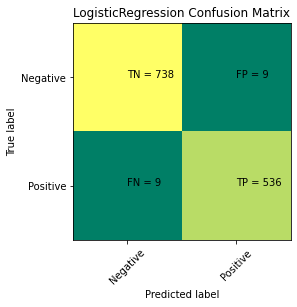

In [52]:
# Print the confusion matrix in a pretty way
cm_visualize(cm_log_tfidf_best, 'Logistic Regression')

#### Random Forest with GridSearchCV

In [53]:
parameters = {
    # 'max_depth': list(range(10, 15)), 
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [100, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
}


rf = RandomForestClassifier(random_state=random_state)
clf_rf_tfidf_cv = GridSearchCV(rf,                        # model
                   param_grid = parameters,   # hyperparameters
                   scoring='f1',              # metric for scoring
                   cv=5)                     # number of folds

clf_rf_tfidf_cv.fit(X_train_tfidf, y_train)

print("Tuned Hyperparameters: ", clf_rf_tfidf_cv.best_params_)
print("F1: ", clf_rf_tfidf_cv.best_score_)

Tuned Hyperparameters:  {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 200}
F1:  0.9819811193364576


In [54]:
# Using the best parameters
clf_rf_tfidf_best = RandomForestClassifier(criterion='gini', max_features='sqrt', 
                                     n_estimators=200, random_state=random_state)

# Train  the model
clf_rf_tfidf_best.fit(X_train_tfidf, y_train)

# Predict the labels of the test instances
y_pred_rf_tfidf_best = clf_rf_tfidf_best.predict(X_test_tfidf)

# Evaluating a classifier
print('Classification report:', '\n', classification_report(y_test, y_pred_rf_tfidf_best, digits=3))
f1_rf_tfidf_best = f1_score(y_test, y_pred_rf_tfidf_best)

Classification report: 
               precision    recall  f1-score   support

           1      0.985     0.984     0.985       747
           2      0.978     0.980     0.979       545

    accuracy                          0.982      1292
   macro avg      0.982     0.982     0.982      1292
weighted avg      0.982     0.982     0.982      1292



In [55]:
# Print the confusion matrix
cm_rf_tfidf_best = cm_calculate(y_test, y_pred_rf_tfidf_best)

Confusion matrix: 
 [[735  12]
 [ 11 534]]


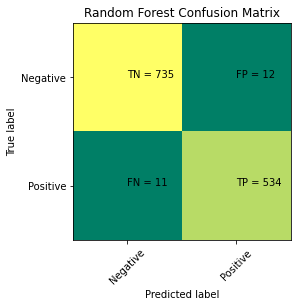

In [56]:
# Print the confusion matrix in a pretty way
cm_visualize(cm_rf_tfidf_best, 'Random Forest')

### Compare models

In [57]:
# Compare models using f1 score
print(f"""Logistic Regression (CountVectorizer + GridSearchCV): {f1_log_count_best}\n
      Random Forest (CountVectorizer + GridSearchCV): {f1_rf_count_best}\n
      Logistic Regression (TFIDFVectorizer + GridSearchCV) {f1_log_tfidf_best}\n
      Random Forest (TFIDFVectorizer + GridSearchCV): {f1_rf_tfidf_best}
      """)
# The best model - Logistic Regression (TFIDFVectorizer + GridSearchCV)

Logistic Regression (CountVectorizer + GridSearchCV): 0.9858585858585858
Random Forest (CountVectorizer + GridSearchCV): 0.9846564376250834
Logistic Regression (TFIDFVectorizer + GridSearchCV) 0.9879518072289156
Random Forest (TFIDFVectorizer + GridSearchCV): 0.984594775619558
